In [617]:
from dotenv import load_dotenv
# from helper.general import split_by_date, generate_value_in_buckets, truncate_to_same_length, validate_path, get_repository_paths
# from helper.significance import check_normality_of_buckets, use_normality_results_for_significance_independent
import logging
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import ast

load_dotenv(override=True)

True

In [618]:
RESULTS_DIRECTORY = os.getenv("RESULTS_DIRECTORY")
PARTICIPANTS_TO_REMOVE = ast.literal_eval(os.getenv("PARTICIPANTS_TO_REMOVE", ""))
BUCKET_SIZE = os.getenv("BUCKET_SIZE")

In [ ]:
import json 
mapping_path = f'{RESULTS_DIRECTORY}/by_person/mapping.json'

# Load the mapping JSON
with open(mapping_path, 'r') as f:
    participant_mapping = json.load(f)

order_of_repositories = list(participant_mapping[key]['SYNONYM'] for key in participant_mapping.keys() if 'XX' not in participant_mapping[key]['SYNONYM'])
renaming_dict = {key: participant_mapping[key].get('SYNONYM', key) for key in participant_mapping.keys()}
renaming_dict

In [620]:
# mirror renaming_dict so that key = value and value = key
renaming_dict_mirror = {v: k for k, v in renaming_dict.items()}

In [621]:
merged_df_for_filtering = pd.read_csv(f"{RESULTS_DIRECTORY}/merged_metrics_{BUCKET_SIZE}.csv")

def filter_and_remove_participants(df, participant_column='participantId'):
    if PARTICIPANTS_TO_REMOVE:
        df = df[~df[participant_column].isin(PARTICIPANTS_TO_REMOVE)]
    participants_of_merged = merged_df_for_filtering['repository'].unique()
    # rename participants_of_merged to match the renaming_dict
    participants_of_merged = [renaming_dict_mirror.get(repo, repo) for repo in participants_of_merged]
    

    df = df[df[participant_column].isin(participants_of_merged)]
    # Reset index after filtering

    df.reset_index(drop=True, inplace=True)
    return df

In [622]:
merged_df_for_filtering['repository']

0      P1
1     P10
2     P11
3     P12
4     P13
5     P14
6      P2
7      P3
8      P4
9      P5
10     P6
11     P7
12     P8
13     P9
Name: repository, dtype: object

In [623]:
path_to_questionnaire_storage = '/Users/annemariewittig/Master/codeprodllm-surveys/COMP/ini'
company = RESULTS_DIRECTORY.split('/')[-1]


In [624]:
def append_questionnaire_averages(df: pd.DataFrame, keep_id: bool = False, name_column: str = 'participantId') -> pd.DataFrame:
    """
    Filters questionnaire DataFrame to include only columns with values exclusively in [1, 2, 3, 4, 5],
    computes column-wise averages, and appends them as a new row.

    Parameters:
        df (pd.DataFrame): Original questionnaire responses.
        keep_id (bool): Whether to keep the 'participantId' column.
        name_column (str): Name of the column to keep if `keep_id` is True.

    Returns:
        pd.DataFrame: Filtered DataFrame with an additional row for averages.
    """
    VALID_VALUES = set(range(1, 6))

    # Identify numeric columns with only valid values
    numeric_cols = [
        col for col in df.select_dtypes(include='number').columns
        if set(df[col].dropna().unique()).issubset(VALID_VALUES)
    ]

    columns = numeric_cols.copy()
    if keep_id and name_column in df.columns:
        columns = [name_column] + columns

    filtered_df = df[columns].copy()

    # Compute averages only for numeric columns, set name column cell value to Average
    avg_row = {col: filtered_df[col].median() if col in numeric_cols else None for col in columns}
    # Set the name column cell value to "Average" if keep_id is True and name_column is present
    if keep_id and name_column in avg_row:
        avg_row[name_column] = "Average"
    filtered_df_with_avg = pd.concat([filtered_df, pd.DataFrame([avg_row], index=[filtered_df.index.max() + 1 if len(filtered_df) > 0 else 0])])

    return filtered_df_with_avg


In [625]:

path_to_company_folder = path_to_questionnaire_storage.replace('COMP', company)

for file in os.listdir(path_to_company_folder):
    if file.endswith('.csv'):
        path_to_file = os.path.join(path_to_company_folder, file)
        logging.info(f'Processing file: {path_to_file}')
        
        df = pd.read_csv(path_to_file, index_col=False)
        # Rename all columns: split at first. use [0]
        df.columns = df.columns.str.split('.').str[0]
        
        # Remove participants that are in PARTICIPANTS_TO_REMOVE
        df = filter_and_remove_participants(df)
        
        df_with_avg = append_questionnaire_averages(df)
        df_with_avg = df_with_avg.round(2)
        print(df_with_avg) 

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    progExpCompared[CEE1]  progExpCompared[CTE]  progExpCompared[PE]  \
0                     3.0                   3.0                  2.0   
1                     3.0                   3.0                  3.0   
2                     4.0                   4.0                  4.0   
3                     5.0                   5.0                  5.0   
4                     2.0                   3.0                  3.0   
5                     4.0                   4.0                  4.0   
6                     5.0                   5.0                  5.0   
7                     3.0                   3.0                  1.0   
8                     3.0                   3.0                  3.0   
9                     3.0                   4.0                  3.0   
10                    3.0                   4.0                  3.0   
11                    3.0                   3.0   

/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


# Plot response distribution

In [626]:
# --- Title generation using question_mapping ---
def get_full_question_title(column: str, question_mapping: dict = None, title_prefix: str = None) -> str:
    if question_mapping is None:
        return f"{title_prefix}: {column}"

    match = re.match(r"^([^\[]+)(?:\[([\w\d_]+)\])?$", column)
    if not match:
        return f"{title_prefix}: {column}".replace('...', '')

    question_id, subkey = match.groups()
    question_data = question_mapping.get(question_id, None)

    if not question_data:
        return f"{title_prefix}: {column}".replace('...', '')

    qtext = question_data.get("question", question_id)
    if subkey and "subquestions" in question_data:
        subtext = question_data["subquestions"].get(subkey, f"[{subkey}]")
        return f"{qtext}\n{subtext}".replace('...', '')
    return qtext.replace('...', '')

In [627]:
import matplotlib.pyplot as plt
import pandas as pd
import re

def plot_questionnaire_distributions(
    df: pd.DataFrame,
    title_prefix: str = "Distribution",
    question_mapping: dict = None
):
    """
    Plots histograms of numeric questionnaire columns limited to answers in [1–5],
    with optional title mapping support for matrix-style or regular questions.

    Parameters:
        df (pd.DataFrame): Input DataFrame of responses.
        title_prefix (str): Prefix for plot titles.
        question_mapping (dict): Optional question structure map.
    """
    VALID_VALUES = set(range(1, 6))

    # Drop columns where all values are NaN
    df = df.dropna(axis=1, how='all')
    def is_valid_column(series: pd.Series) -> bool:
        try:
            values = pd.to_numeric(series.dropna(), errors='raise')
            return values.apply(lambda x: x in VALID_VALUES).all()
        except Exception:
            return False

    valid_cols = [col for col in df.columns if is_valid_column(df[col])]

    if not valid_cols:
        print("No columns with strictly numeric values in 1–5.")
        return

    filtered_df = df[valid_cols].apply(pd.to_numeric)

    # --- Plotting ---
    n_cols = len(filtered_df.columns)
    n_rows = (n_cols + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(18, n_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, col in enumerate(filtered_df.columns):
        ax = axes[i]
        values = filtered_df[col].dropna()
        avg = values.median()

        ax.hist(values, bins=[0.5 + i for i in range(6)], edgecolor='black', rwidth=0.8)
        ax.axvline(avg, color='red', linestyle='--', linewidth=2, label=f'Avg: {avg:.2f}')
        ax.set_title(get_full_question_title(col, question_mapping, title_prefix), fontsize=11)
        ax.set_xlabel("Antwort (1–5)")
        ax.set_ylabel("Anzahl")
        ax.set_xticks(range(1, 6))
        ax.set_xlim(0.5, 5.5)
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()


In [ ]:
import json
with open('/path/to/questionnaire_mapping.json', 'r') as f:
    question_mapping = json.load(f)

Index(['participantId', 'projectSize', 'projectteam'], dtype='object')
No columns with strictly numeric values in 1–5.
Index(['participantId', 'education', 'framework', 'ide',
       'profYearsProgramming', 'progExp', 'progExpCompared[CEE1]',
       'progExpCompared[CTE]', 'progExpCompared[PE]', 'progLang',
       'progLangExp[CSharp]', 'progLangExp[C]', 'progLangExp[Java]',
       'progLangExp[Other]', 'progLangExp[Plus]', 'progLangExp[Python]',
       'progLangExp[TSJS]', 'yearsProgramming'],
      dtype='object')


/Users/annemariewittig/Master/repo-analysis/venv/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


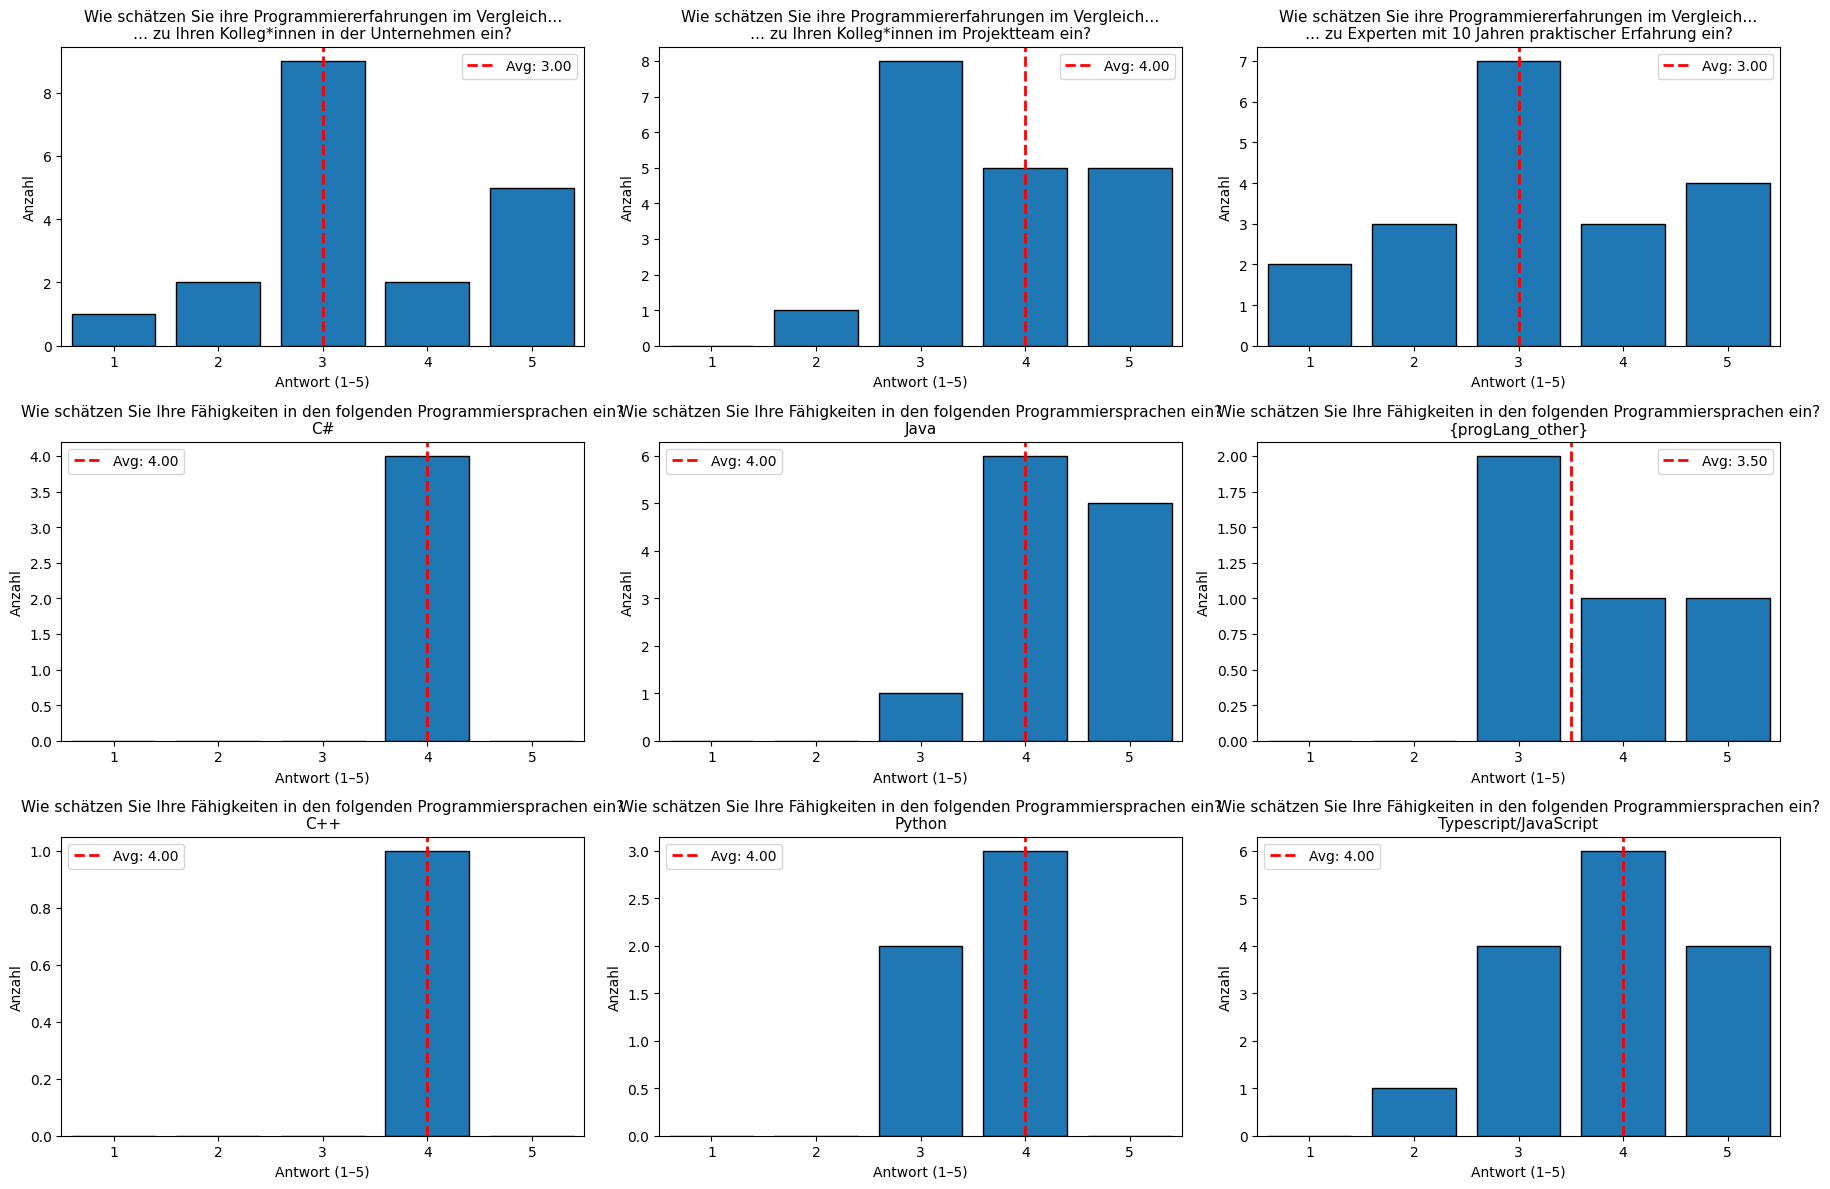

Index(['participantId', 'expMatr11[1]', 'expMatr11[2]', 'expMatr11[3]',
       'expMatr11[4]', 'expMatr11[5]', 'expMatr11[6]', 'expMatr2[10]',
       'expMatr2[11]', 'expMatr2[12]', 'expMatr2[7]', 'expMatr2[8]',
       'expMatr2[9]', 'expMatr3[a]', 'expMatr3[b]', 'expMatr3[c]',
       'expMatr3[d]', 'expMatr3[e]', 'expMatr3[f]', 'expMatr3[g]',
       'expMatr3[h]', 'expMatr3[i]', 'expMatr3[j]', 'expMatr3[k]',
       'expMatr3[l]', 'expMatr3[m]', 'expMatr3[n]', 'expProCont', 'newTasks',
       'noTask'],
      dtype='object')


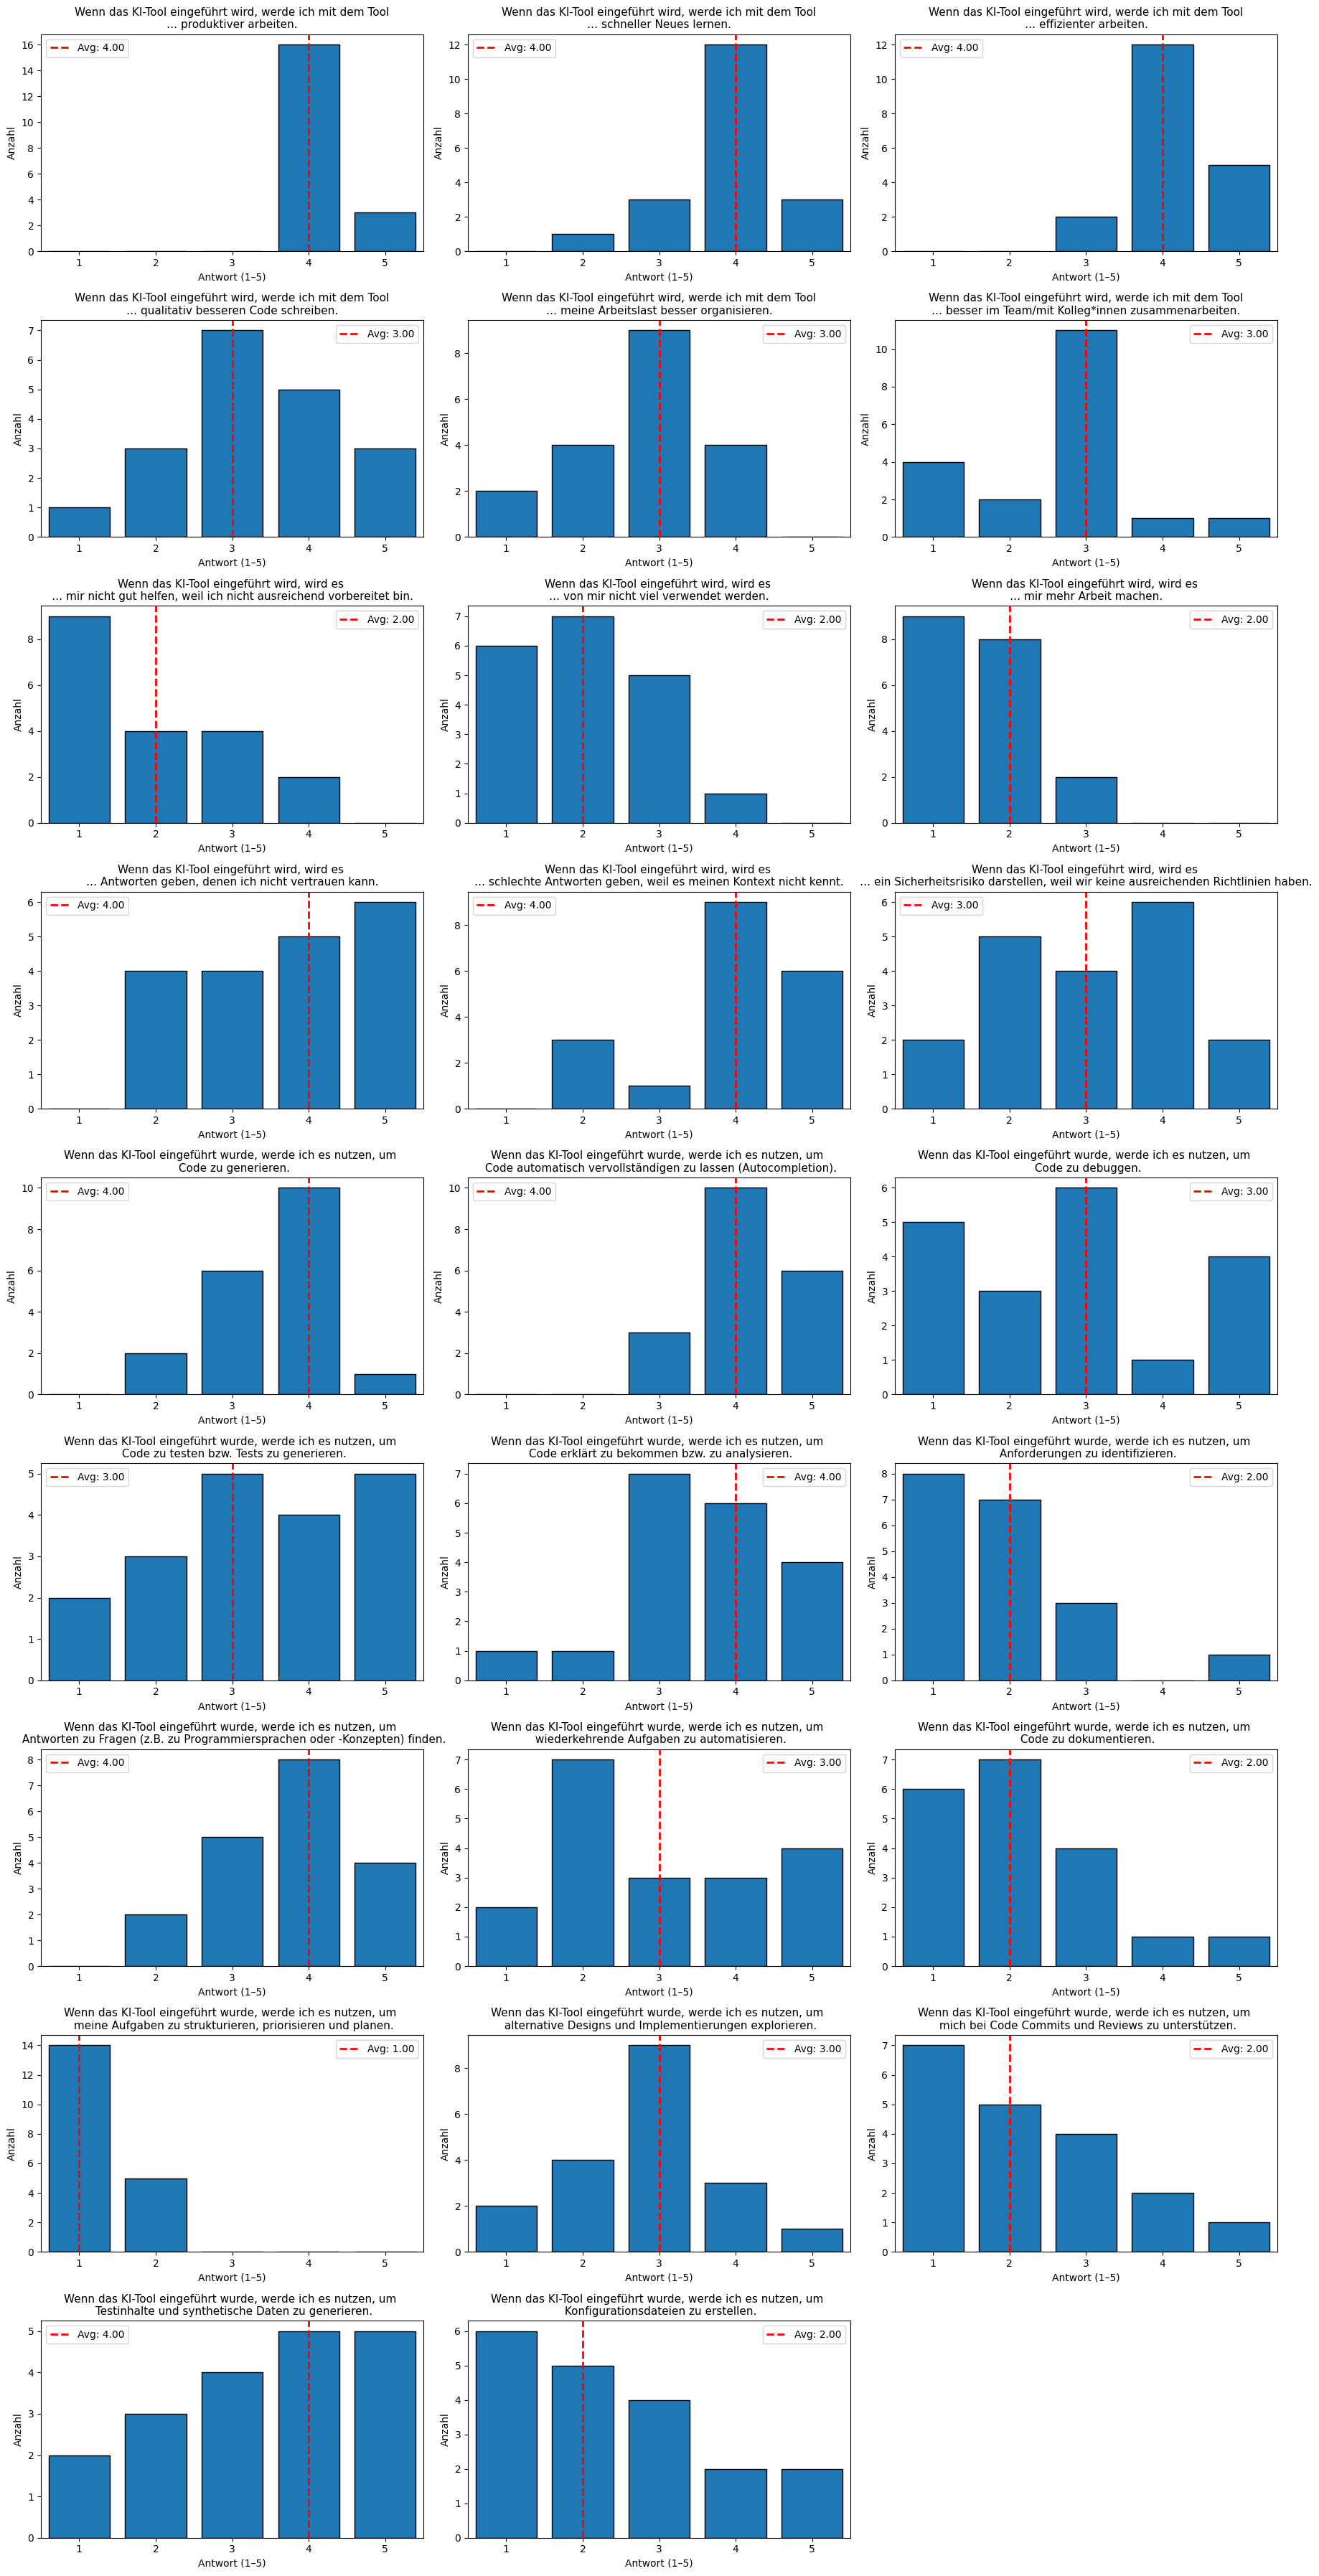

Index(['participantId', 'aiToolsInWork', 'maxPotWork', 'reasonMaxPotWork',
       'satisfactionWork', 'usageFrequencyWork', 'usageTimeWork'],
      dtype='object')


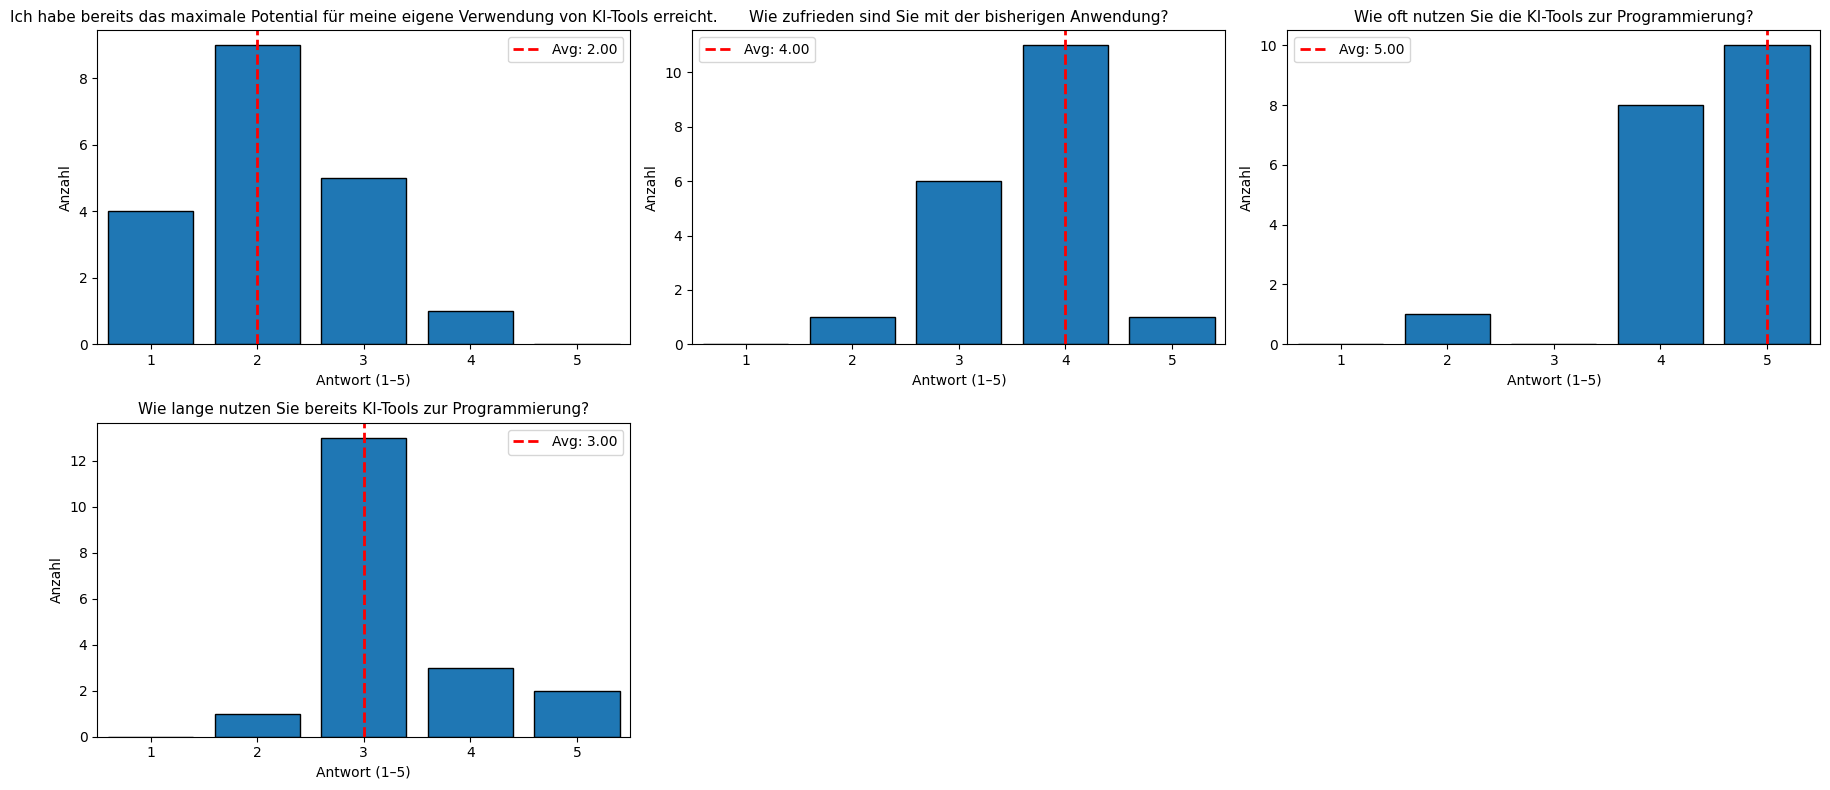

In [629]:

path_to_company_folder = path_to_questionnaire_storage.replace('COMP', company)

for file in os.listdir(path_to_company_folder):
    if file.endswith('.csv'):
        path_to_file = os.path.join(path_to_company_folder, file)
        logging.info(f'Processing file: {path_to_file}')
        
        df = pd.read_csv(path_to_file, index_col=False)  
        # Rename all columns: split at first. use [0]
        df.columns = df.columns.str.split('.').str[0]
        print(df.columns)
        df_with_avg = append_questionnaire_averages(df)
        df_with_avg = df_with_avg.round(2)
        plot_questionnaire_distributions(df, title_prefix="Survey Question", question_mapping=question_mapping)

# Check for differences across groups found in data

In [ ]:
blue_group = ['P1', 'bznd2hh7ii', 'k1bu0cscd4', 'P10', 'P13', 'P14']
red_group = ['P2', 'P5']
mixed_group = ['P4', 'P7', 'P6', 'P8', 'P9', 'P11', 'P12']
trendless_group = ['5x4imrvk5b', 'P3']

In [631]:
print(len(blue_group), len(red_group), len(mixed_group), len(trendless_group))

6 2 7 2


In [632]:
def filter_by_cell_values(df: pd.DataFrame, column: str, values: list) -> pd.DataFrame:
    """
    Filters DataFrame by specific values in a given column.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        column (str): Column name to filter by.
        values (list): List of values to filter for.

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    filtered_df = df[df[column].isin(values)]
    return filtered_df


In [633]:
blue_group_df = None
red_group_df = None
mixed_group_df = None
trendless_group_df = None

def merge_dfs (df1, df2, merge_column):
    if df1 is None:
        return df2.round(2)
    elif df2 is None:
        return df1.round(2)
    # Use 'outer' merge when you want to keep all rows from both DataFrames, filling with NaN where data is missing.
    # Use 'inner' merge when you want only the rows with keys present in both DataFrames.
    # Use 'left' merge when you want all rows from df1 and only matching rows from df2.
    new_df = pd.merge(df1, df2, on=merge_column, how='outer').round(2)
    return new_df
    

for file in os.listdir(path_to_company_folder):
    if file.endswith('.csv'):
        path_to_file = os.path.join(path_to_company_folder, file)
        logging.info(f'Processing file: {path_to_file}')
        
        df = pd.read_csv(path_to_file, index_col=False)  

        # Drop rows if entirely NaN
        df = df.dropna(how='all')
        
        # Rename all columns: split at first. use [0]
        df.columns = df.columns.str.split('.').str[0]
        # df = filter_and_remove_participants(df)

        blue_group_df = merge_dfs(blue_group_df, filter_by_cell_values(df, 'participantId', blue_group), 'participantId')
        red_group_df = merge_dfs(red_group_df, filter_by_cell_values(df, 'participantId', red_group), 'participantId')
        mixed_group_df = merge_dfs(mixed_group_df, filter_by_cell_values(df, 'participantId', mixed_group), 'participantId')
        trendless_group_df = merge_dfs(trendless_group_df, filter_by_cell_values(df, 'participantId', trendless_group), 'participantId')
        
        print(len(blue_group_df))
        print(len(red_group_df))
        print(len(mixed_group_df))
        print(len(trendless_group_df))


5
2
7
1
5
2
7
1
5
2
7
1
5
2
7
1


In [ ]:
# drop NaN columns
red_group_df = append_questionnaire_averages(red_group_df, keep_id=True, name_column='participantId')
blue_group_df = append_questionnaire_averages(blue_group_df, keep_id=True, name_column='participantId')
mixed_group_df = append_questionnaire_averages(mixed_group_df, keep_id=True, name_column='participantId')
trendless_group_df = append_questionnaire_averages(trendless_group_df, keep_id=True, name_column='participantId')
blue_group_df = blue_group_df.dropna(axis=1, how='all')
red_group_df = red_group_df.dropna(axis=1, how='all')
mixed_group_df = mixed_group_df.dropna(axis=1, how='all')
trendless_group_df = trendless_group_df.dropna(axis=1, how='all')

red_group_df

In [635]:
print(len(red_group_df['participantId'].unique()) -1)
print(len(blue_group_df['participantId'].unique()) -1)
print(len(mixed_group_df['participantId'].unique()) -1)
print(len(trendless_group_df['participantId'].unique()) -1)

2
5
7
1


In [636]:
average_row_red_group = red_group_df.iloc[-1].copy()
average_row_red_group['participantId'] = 'Positive'
average_row_blue_group = blue_group_df.iloc[-1].copy()
average_row_blue_group['participantId'] = 'Negative'
average_row_mixed_group = mixed_group_df.iloc[-1].copy()
average_row_mixed_group['participantId'] = 'Mixed'
average_row_trendless_group = trendless_group_df.iloc[-1].copy()
average_row_trendless_group['participantId'] = 'Trendless'

overview_df = pd.DataFrame([average_row_red_group, average_row_blue_group, average_row_mixed_group, average_row_trendless_group])
overview_df.rename(columns={'participantId': 'Group'}, inplace=True)
overview_df = overview_df.round(2)
overview_df

,Group,progExpCompared[CEE1],progExpCompared[CTE],progExpCompared[PE],progLangExp[Java],progLangExp[TSJS],expMatr11[1],expMatr11[2],expMatr11[3],expMatr11[4],...,expMatr3[n],maxPotWork,satisfactionWork,usageFrequencyWork,usageTimeWork,progLangExp[CSharp],progLangExp[Python],progLangExp[Other],progLangExp[Plus],yearsProgramming
2,Positive,2.5,3.0,3.0,4.0,4.0,4.0,3.5,4.0,3.5,...,2.5,2.5,2.5,3.0,3.0,NaN,NaN,NaN,NaN,NaN
5,Negative,3.0,4.0,3.0,4.5,5.0,4.0,4.0,4.0,4.0,...,1.0,2.0,4.0,4.0,3.0,4.0,3.0,NaN,NaN,NaN
7,Mixed,3.0,4.0,3.0,4.5,4.0,4.0,4.0,4.0,3.0,...,2.0,2.0,4.0,5.0,3.0,4.0,3.5,3.5,4.0,NaN
1,Trendless,5.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,5.0,...,5.0,2.0,3.0,4.0,3.0,NaN,4.0,NaN,NaN,4.0


In [637]:
# Define custom hex colors for each group
GROUP_COLORS = {
    'Positive': '#BD6261',    # Red
    'Negative': '#4672AF',    # Blue  
    'Mixed': '#816C89',       # Orange
    'Trendless': 'black'    # Green
}


In [ ]:


print("Current group colors:")
for group, color in GROUP_COLORS.items():
    print(f"{group}: {color}")

Current group colors:
Positive: #BD6261
Negative: #4672AF
Mixed: #816C89
Trendless: black


In [639]:
prog_exp_columns = ['Group'] + [col for col in overview_df.columns if 'progLangExp' in col]
application_columns = ['Group'] + [col for col in overview_df.columns if 'expMatr3' in col]
other_columns = list(set(overview_df.columns) - set(prog_exp_columns) - set(application_columns))
acting_matrix_columns = ['Group'] + [col for col in other_columns if 'expMatr11' in col]
issue_matrix_columns = ['Group'] + [col for col in other_columns if 'expMatr2' in col]

comparison_columns = ['Group'] + [col for col in overview_df.columns if 'Compared' in col]
other_columns = list(set(other_columns) - set(acting_matrix_columns) - set(issue_matrix_columns))
other_columns = ['Group'] + other_columns

overview_df_programming_languages = overview_df[prog_exp_columns].reset_index(drop=True).copy()
overview_df_other = overview_df[list(other_columns)].reset_index(drop=True).copy()
overview_df_acting_matrixes = overview_df[list(acting_matrix_columns)].reset_index(drop=True).copy()
overview_df_issue_matrixes = overview_df[list(issue_matrix_columns)].reset_index(drop=True).copy()
overview_df_application = overview_df[application_columns].reset_index(drop=True).copy()
overview_df_comparison = overview_df[comparison_columns].reset_index(drop=True).copy()

print(len(overview_df.columns))
print(len(overview_df_programming_languages.columns))
print(len(overview_df_other.columns))
print(len(overview_df_application.columns))
print(len(overview_df_acting_matrixes.columns))
print(len(overview_df_issue_matrixes.columns))
print(len(overview_df_comparison.columns))

41
7
9
15
7
7
4


In [640]:
def rename_columns_using_mapping(df: pd.DataFrame, mapping: dict) -> pd.DataFrame:
    df.rename(columns=mapping, inplace=True)
    return df

with open('/Users/annemariewittig/Master/codeprodllm-surveys/flattened_ini_mapping.json', 'r') as f:
    rename_mapping = json.load(f)

In [641]:
overview_df_programming_languages = rename_columns_using_mapping(overview_df_programming_languages, rename_mapping)
overview_df_other = rename_columns_using_mapping(overview_df_other, rename_mapping)
overview_df_application = rename_columns_using_mapping(overview_df_application, rename_mapping)
overview_df_acting_matrixes = rename_columns_using_mapping(overview_df_acting_matrixes, rename_mapping)
overview_df_issue_matrixes = rename_columns_using_mapping(overview_df_issue_matrixes, rename_mapping)
overview_df_comparison = rename_columns_using_mapping(overview_df_comparison, rename_mapping)

In [642]:
overview_df_programming_languages

,Group,Java,Typescript/JavaScript,C#,Python,{progLang_other},C++
0,Positive,4.0,4.0,NaN,NaN,NaN,NaN
1,Negative,4.5,5.0,4.0,3.0,NaN,NaN
2,Mixed,4.5,4.0,4.0,3.5,3.5,4.0
3,Trendless,4.0,4.0,NaN,4.0,NaN,NaN


In [643]:
overview_df_other

,Group,…compared to all colleagues,Years of private programming experience,How satisfied are you with the application so far?,…compared to experts,…compared to team colleagues,I have already reached the maximum potential for my own use of AI tools.,How long have you been using AI tools for programming?,usageFrequencyWork
0,Positive,2.5,NaN,2.5,3.0,3.0,2.5,3.0,3.0
1,Negative,3.0,NaN,4.0,3.0,4.0,2.0,3.0,4.0
2,Mixed,3.0,NaN,4.0,3.0,4.0,2.0,3.0,5.0
3,Trendless,5.0,4.0,3.0,4.0,5.0,2.0,3.0,4.0


In [644]:
overview_df_application.T

,0,1,2,3
Group,Positive,Negative,Mixed,Trendless
code generation,3.5,4.0,3.0,4.0
autocompletion,4.5,4.0,4.0,4.0
code debugging,2.5,3.0,2.0,5.0
code testing or test generation,4.5,3.0,3.0,5.0
code explanation and analysis,4.0,3.0,3.0,5.0
requirement identification,2.0,2.0,1.0,1.0
question answering,3.0,4.0,3.0,5.0
recurring task automation,3.5,2.0,2.0,5.0
code documentation,2.0,2.0,2.0,1.0


In [645]:
overview_df_acting_matrixes.T

,0,1,2,3
Group,Positive,Negative,Mixed,Trendless
… work better in a team/with colleagues.,3.0,3.0,3.0,3.0
… work more productively.,4.0,4.0,4.0,4.0
… write better quality code.,3.5,4.0,3.0,5.0
… organize my workload better.,4.0,3.0,3.0,2.0
… work more efficiently.,4.0,4.0,4.0,3.0
… learn new things faster.,3.5,4.0,4.0,4.0


In [646]:
overview_df_issue_matrixes.T

,0,1,2,3
Group,Positive,Negative,Mixed,Trendless
… pose a security risk due to inadequate policies.,4.5,2.0,3.0,1.0
… not be used much by me.,2.5,2.0,2.0,4.0
… give answers I cannot trust.,4.0,3.0,4.0,2.0
… give bad answers due to lack of context.,4.0,4.0,5.0,4.0
… can't help much as I'm unprepared.,3.0,2.0,1.0,1.0
… give me more work.,2.5,2.0,1.0,1.0


In [647]:
overview_df_comparison.T

,0,1,2,3
Group,Positive,Negative,Mixed,Trendless
…compared to all colleagues,2.5,3.0,3.0,5.0
…compared to team colleagues,3.0,4.0,4.0,5.0
…compared to experts,3.0,3.0,3.0,4.0


# Visualize the Groups

In [648]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec

def plot_transposed_grouped_heatmap_with_title_and_colorbar(
    df: pd.DataFrame,
    title_spacing=0.95,
    cmap="RdYlGn",
    figsize=(12, 8),
    title="Effect Sizes by Language and Group",
    cbar_label="Effect Size",
    vmin=1.0,
    vmax=5.0,
    path=None,
    plot_size_only=False,
    cell_width=0.8,
    cell_height=None,  # If None, uses cell_width for square cells
    rotation=90,
    height_ratio=[0.05, 0.95],
    hspace=0.05,
    top_padding=0,
    additional_label="",
    label_padding=0,
    color_bar=True,
    group_colors=None  # New parameter for group colors
):
    # Prepare data
    df_transposed = df.set_index("Group").T
    
    if plot_size_only:
        # Use cell_width for height if cell_height not specified
        if cell_height is None:
            cell_height = cell_width
            
        # Calculate figure size based on plot content and desired cell size
        n_rows, n_cols = df_transposed.shape
        plot_width = n_cols * cell_width
        plot_height = n_rows * cell_height + top_padding
        
        # Find the longest x and y tick labels for sizing
        longest_ytick = max([str(label) for label in df_transposed.index], key=len)
        width = len(longest_ytick) * 0.067
        print(width)
        
        # Add space for labels, colorbar, and title
        label_width = width  # Space for y-axis labels
        label_height = 1.5  # Space for x-axis labels and colorbar
        title_height = 0.8 if title else 0.0
        
        total_width = plot_width + label_width
        total_height = plot_height + label_height + title_height
        
        figsize = (total_width, total_height)

    # Define custom grid layout - always create space for colorbar
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=height_ratio, hspace=hspace)
    
    # Title
    if title:
        fig.suptitle(title, fontsize=16, y=title_spacing)

    # Colorbar axis - always create it to reserve space
    cbar_ax = fig.add_subplot(gs[0])

    # Heatmap axis
    ax = fig.add_subplot(gs[1])

    # Heatmap with or without colorbar
    if color_bar:
        sns.heatmap(
            df_transposed,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            linecolor='lightgray',
            cbar_ax=cbar_ax,
            cbar_kws={"orientation": "horizontal", "label": cbar_label},
            ax=ax
        )
        # Format colorbar
        cbar_ax.xaxis.set_label_position('top')
        cbar_ax.xaxis.tick_top()
    else:
        sns.heatmap(
            df_transposed,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            annot=True,
            fmt=".2f",
            linewidths=0.5,
            linecolor='lightgray',
            cbar=False,  # Don't create a default colorbar
            ax=ax
        )
        # Hide the colorbar axis but keep the space
        cbar_ax.set_visible(False)

    # Format axis labels
    ax.set_xlabel("", fontsize=12)
    ax.set_ylabel("", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha="center")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    # Apply custom colors to x-axis labels (group names) if provided
    if group_colors:
        for i, tick_label in enumerate(ax.get_xticklabels()):
            group_name = tick_label.get_text()
            if group_name in group_colors:
                tick_label.set_color(group_colors[group_name])
    
    if additional_label:
        # Place the label right-aligned above the y-axis labels
        ax.text(
            -0.02,  # x position (far right in axis coordinates)
            -0.49 + label_padding,  # y position (above first y-tick)
            additional_label,
            fontsize=10,
            va='bottom',
            ha='right',
            transform=ax.get_yaxis_transform()
        )

    # Layout - use different approach based on plot_size_only
    if plot_size_only:
        # Use subplots_adjust for precise control
        plt.subplots_adjust(
            left=label_width/figsize[0],
            right=0.98,
            bottom=label_height/figsize[1],
            top=0.95 if title else 0.98
        )
    else:
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    
    if path:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches='tight', dpi=300)
    plt.show()


In [649]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# 1. Get the vlag colormap
vlag = cm.get_cmap("vlag")

# 2. Sample the left (blue) and right (red) extremes
left = vlag(np.linspace(0.0, 0.4, 128))       # Blue half
right = vlag(np.linspace(0.6, 1.0, 128))      # Red half

# 3. Define a soft neutral middle color (e.g., light gray)
# You can tweak this: RGB, RGBA, hex, or HSV
middle = np.array([[0.95, 0.95, 0.95, 1.0]])  # Soft neutral (light gray)

# 4. Concatenate the three parts
colors_combined = np.vstack([left, middle, right])

# 5. Create the new colormap
custom_vlag_neutral = LinearSegmentedColormap.from_list("custom_vlag_neutral", colors_combined)


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_80371/3017761426.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  vlag = cm.get_cmap("vlag")


In [650]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

# Load vlag and trim it to remove extremes (e.g., keep 20%–80%)
base = cm.get_cmap("vlag")
colors = base(np.linspace(0.2, 0.8, 256))  # Adjust 0.2 and 0.8 to tune intensity

# Build a new LinearSegmentedColormap
soft_vlag = LinearSegmentedColormap.from_list("soft_vlag", colors)

/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_80371/688280697.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap("vlag")


In [651]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from matplotlib.colors import to_hex


# 1. Get 'vlag' colormap and extract pure left and right colors
vlag = colormaps["vlag"]
ryb = colormaps["RdYlBu_r"]

print(to_hex(vlag(0)))
print(to_hex(vlag(0.99999999)))
left_color = (70/255, 114/255, 175/255, 1)   # Deep blue
middle_color = (255/255, 244/255, 244/255, 1)
right_color = (189/255, 98/255, 97/255, 1)  # Deep red

print("Left color hex:", to_hex(left_color))
print("Middle color hex:", to_hex(middle_color))
print("Right color hex:", to_hex(right_color))

# 2. Interpolate: left → middle, then middle → right
n_colors = 256
n_half = n_colors // 2
left_to_middle = np.linspace(left_color, middle_color, n_half, endpoint=False)
middle_to_right = np.linspace(middle_color, right_color, n_colors - n_half)
gradient_colors = np.vstack([left_to_middle, middle_to_right])

# 3. Create new colormap
custom_gradient = LinearSegmentedColormap.from_list("custom_vlag_extreme", gradient_colors)

#2369bd
#a9373b
Left color hex: #4672af
Middle color hex: #fff4f4
Right color hex: #bd6261


3.0820000000000003


/var/folders/19/fmw641dj3bnfy5qbgqrzmf100000gn/T/ipykernel_80371/2645083009.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap("RdYlBu_r")


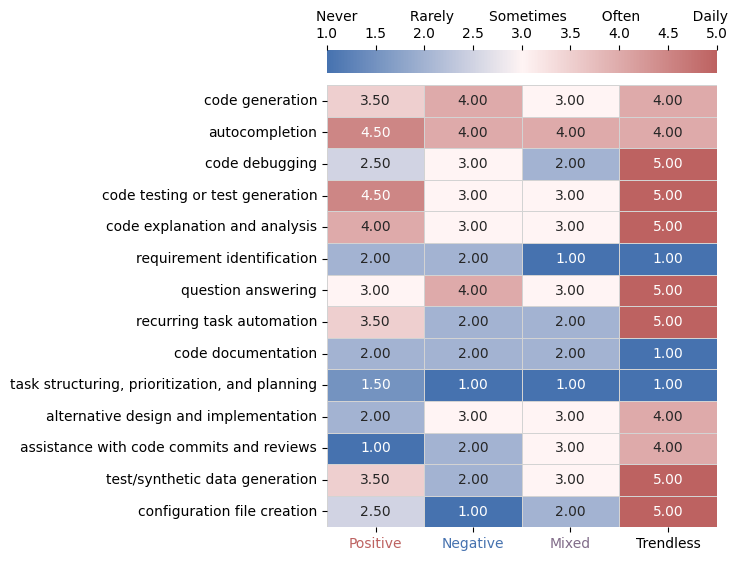

In [652]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt

base = cm.get_cmap("RdYlBu_r")
soft_cmap = colors.LinearSegmentedColormap.from_list(
    "soft_rdylbu", base(np.linspace(0.2, 0.8, 256))  # Skip extremes
)
spacing = 12

plot_transposed_grouped_heatmap_with_title_and_colorbar(
    overview_df_application, 
    title_spacing=0.97, 
    title=None,  #title="Developer's expectations of how often they use Copilot's for specific areas",
    cmap=custom_gradient, 
    cbar_label=f"Never{' ' * spacing}Rarely{' ' * (spacing-4)}Sometimes{' ' * (spacing-4)}Often{' ' * spacing}Daily", 
    vmin=1.0, 
    vmax=5.0, 
    plot_size_only=True,
    cell_width=1.01,  # Width of each cell in inches
    cell_height=0.35, # Height of each cell in inches
    rotation=0,
    path=f'/Users/annemariewittig/Master/repo-analysis/results/{company}/questionnaires/application_expectations.pdf',
    group_colors=GROUP_COLORS  # Add custom group colors
)

1.407


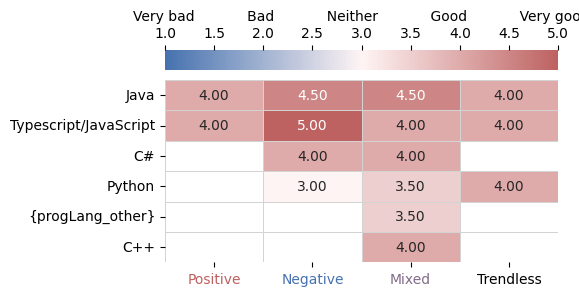

In [653]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt

spacing = 12

plot_transposed_grouped_heatmap_with_title_and_colorbar(
    overview_df_programming_languages, 
    title_spacing=0.97, #title="Developer's experience with programming languages", 
    title=None, 
    cmap=custom_gradient, 
    cbar_label=f"Very bad{' ' * spacing}Bad{' ' * (spacing)}Neither{' ' * (spacing)}Good{' ' * spacing}Very good", 
    vmin=1.0, 
    vmax=5.0,
    plot_size_only=True,
    cell_width=1.01,  # Width of each cell in inches
    cell_height=0.35, # Height of each cell in inches
    rotation=0,
    path=f'/Users/annemariewittig/Master/repo-analysis/results/{company}/questionnaires/proglang_expectations.pdf',
    height_ratio=[0.1, 0.9],
    hspace=0.1,
    top_padding=0.1,
    group_colors=GROUP_COLORS  # Add custom group colors
)

2.68


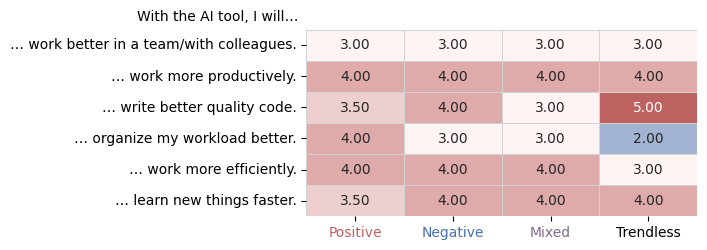

In [654]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt
label = "With the AI tool, I will…"
spacing = 14

plot_transposed_grouped_heatmap_with_title_and_colorbar(
    overview_df_acting_matrixes, 
    title_spacing=1, #title="Developer's agreement with statements regarding their expectations with Copilot", 
    title=None, 
    cmap=custom_gradient, 
    cbar_label=f"Disagree{' ' * (spacing-6)}Disagree{' ' * (spacing-6)}Neither{' ' * (spacing-4)}Agree{' ' * (spacing-2)}Agree\ncompletely{' ' * int(spacing * 4.4)}completely", 
    vmin=1.0, 
    vmax=5.0,
    plot_size_only=True,  # This will calculate figure size based on plot content
    cell_width=1.01,  # Width of each cell
    cell_height=0.35, # Height of each cell (optional, defaults to cell_width if not specified)
    path=f'/Users/annemariewittig/Master/repo-analysis/results/{company}/questionnaires/matrix_work_expectations.pdf',
    height_ratio=[0.1, 0.9],
    top_padding=0.1,
    rotation=0,
    additional_label=label,
    label_padding=0.3,
    color_bar=False,
    group_colors=GROUP_COLORS  # Add custom group colors
)

3.35


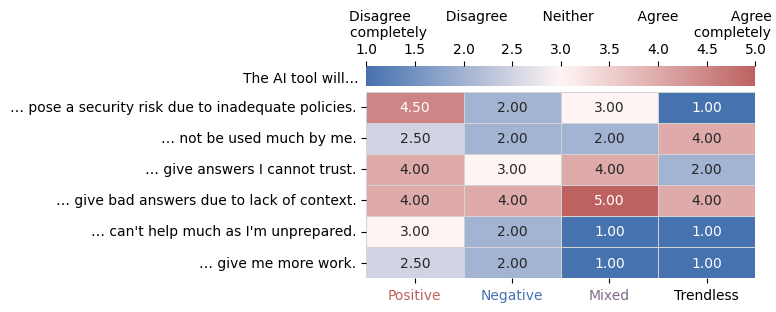

In [655]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt
label = "The AI tool will…"
spacing = 14

plot_transposed_grouped_heatmap_with_title_and_colorbar(
    overview_df_issue_matrixes, 
    title_spacing=1, #title="Developer's agreement with statements regarding their expectations with Copilot", 
    title=None, 
    cmap=custom_gradient, 
    cbar_label=f"Disagree{' ' * (spacing-6)}Disagree{' ' * (spacing-6)}Neither{' ' * (spacing-4)}Agree{' ' * (spacing-2)}Agree\ncompletely{' ' * int(spacing * 4.4)}completely", 
    vmin=1.0, 
    vmax=5.0,
    plot_size_only=True,  # This will calculate figure size based on plot content
    cell_width=1.01,  # Width of each cell
    cell_height=0.35, # Height of each cell (optional, defaults to cell_width if not specified)
    path=f'/Users/annemariewittig/Master/repo-analysis/results/{company}/questionnaires/matrix_problems_expectations.pdf',
    height_ratio=[0.1, 0.9],
    top_padding=0.1,
    rotation=0,
    additional_label=label,
    label_padding=0.3,
    group_colors=GROUP_COLORS  # Add custom group colors
)

1.8760000000000001


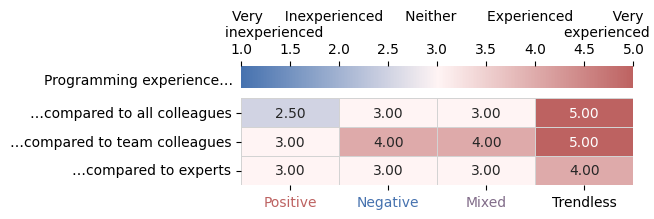

In [656]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt

spacing = 11
label =  "Programming experience…"

plot_transposed_grouped_heatmap_with_title_and_colorbar(
    overview_df_comparison, 
    title_spacing=3, #title="Developer's self-perceived experience compared to...", 
    title=None, 
    cmap=custom_gradient, 
    cbar_label=f"Very{' ' * (spacing-6)}Inexperienced{' ' * (spacing-6)}Neither{' ' * (spacing-4)}Experienced{' ' * (spacing-2)}Very\ninexperienced{' ' * int(spacing * 5)}experienced", 
    vmin=1.0, 
    vmax=5.0,
    plot_size_only=True,
    cell_width=1.01,  # Width of each cell in inches
    cell_height=0.35, # Height of each cell in inches
    path=f'/Users/annemariewittig/Master/repo-analysis/results/{company}/questionnaires/comparison_expectations.pdf',
    rotation=0,
    height_ratio=[0.2, 0.8],
    hspace=0.2,
    top_padding=0.2,
    additional_label=label,
    label_padding=0.1,
    group_colors=GROUP_COLORS  # Add custom group colors
)

4.824


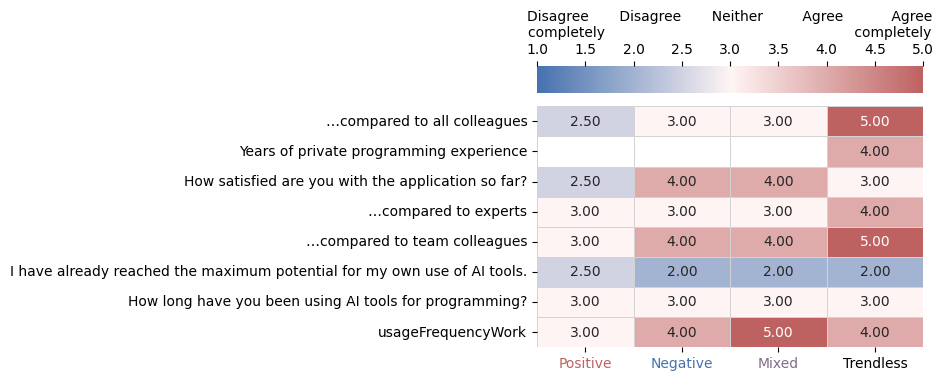

In [657]:
from matplotlib import cm, colors
import matplotlib.pyplot as plt

spacing = 13

plot_transposed_grouped_heatmap_with_title_and_colorbar(
    overview_df_other, 
    title_spacing=1, #title="Developer's agreement with statements regarding their expectations with Copilot", 
    title=None, 
    cmap=custom_gradient, 
    cbar_label=f"Disagree{' ' * (spacing-6)}Disagree{' ' * (spacing-6)}Neither{' ' * (spacing-4)}Agree{' ' * (spacing-2)}Agree\ncompletely{' ' * int(spacing * 4.4)}completely", 
    vmin=1.0, 
    vmax=5.0,
    plot_size_only=True,
    cell_width=1.01,  # Width of each cell in inches
    cell_height=0.35, # Height of each cell in inches
    path=f'/Users/annemariewittig/Master/repo-analysis/results/{company}/questionnaires/other_expectations.pdf',
    rotation=0,
    height_ratio=[0.1, 0.9],
    hspace=0.1,
    top_padding=0.1,
    group_colors=GROUP_COLORS  # Add custom group colors
)

# Correlate the answers with the metrics

In [658]:
BUCKET_SIZE = os.getenv("BUCKET_SIZE")
metric_results = pd.read_csv(f'/Users/annemariewittig/Master/repo-analysis/results/{company}/merged_metrics_{BUCKET_SIZE}.csv', index_col=False)  
metric_results.columns

Index(['repository', 'M1', 'M2', 'M7', 'commits_coupling', 'commits_loc_added',
       'commits_loc_changed', 'commits_loc_deleted', 'commits_total',
       'pull_requests_successful', 'pull_requests_time_to_close',
       'pull_requests_time_to_merge', 'pull_requests_total', 'releases',
       'time_to_merge_into_main'],
      dtype='object')

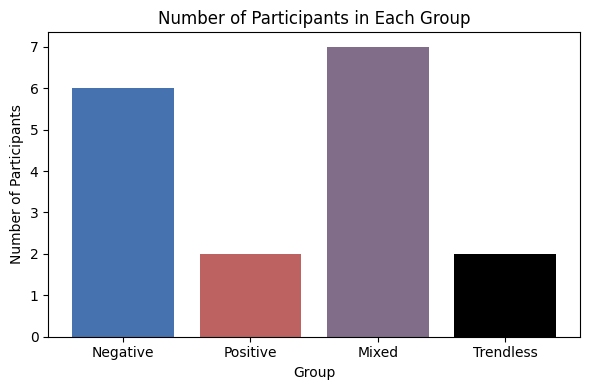

In [660]:
import matplotlib.pyplot as plt

group_names = ['Negative', 'Positive', 'Mixed', 'Trendless']
group_lengths = [len(blue_group), len(red_group), len(mixed_group), len(trendless_group)]

# Use the same custom colors defined in GROUP_COLORS
bar_colors = [GROUP_COLORS[group] for group in group_names]

plt.figure(figsize=(6, 4))
plt.bar(group_names, group_lengths, color=bar_colors)
plt.xlabel('Group')
plt.ylabel('Number of Participants')
plt.title('Number of Participants in Each Group')
plt.tight_layout()
plt.show()